# Plot structural data (RDFs) from pairwise distance data

## Setup

In [1]:
# Standard library
from dataclasses import dataclass
import json
import os
from pathlib import Path
import re
import sys
import time
import warnings

# Third party packages
import cmasher as cmr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import MDAnalysis as mda
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from tqdm.auto import tqdm

# Jupyter notebook
from IPython.display import Image

# get absolute path to file's parent directory
dir_proj_base = Path(os.getcwd()).resolve().parents[2]
sys.path.insert(0, f"{dir_proj_base}/src")

# Internal dependencies
from figures.style import set_style  # noqa: E402
from stats.block_error import BlockError  # noqa: E402


/nfs/zeal_mount/aglisman/miniconda3/envs/analysis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
cwd = os.getcwd()
set_style()


In [3]:
def natural_sort(l):
    def convert(text):
        if text.isdigit():
            return int(text)
        else:
            return text.lower()

    def alphanum_key(key):
        if type(key) is not str:
            key = str(key)
        return [convert(c) for c in re.split("([0-9]+)", key)]

    return sorted(l, key=alphanum_key)


## Data loading

In [4]:
# variable inputs
data_base_path = Path("./../output/")
print(f"Data path: '{data_base_path}'")

info_dir = "mdanalysis/data/"
pd_dir = "mdanalysis_contact_matrix/data/"


Data path: '../output'


In [5]:
# find all subdirectories (tags)
simulation_paths = natural_sort([x for x in data_base_path.iterdir() if x.is_dir() and "2PAcr-16mer" in x.name])
# drop paths containing "Ace-" or "Alc-"
simulation_paths = [x for x in simulation_paths if "Ace-" not in x.name and "Alc-" not in x.name]

tags = [x.name for x in simulation_paths]
print(f"Found {len(tags)} simulation directories")


Found 6 simulation directories


In [6]:
@dataclass(frozen=False, order=True)
class Data:
    tag: str
    info: dict
    selection: dict
    n_Ca: int

    # pair distance matrices
    df_dist_calpha_ab: pd.DataFrame
    df_dist_calpha: pd.DataFrame
    df_dist_ccarboxy: pd.DataFrame

    df_dist_na_ccarboxy: pd.DataFrame
    df_dist_na_ocarboxy: pd.DataFrame
 
    df_dist_ca_ccarboxy: pd.DataFrame
    df_dist_ca_ocarboxy: pd.DataFrame
    
    df_dist_na_cl: pd.DataFrame
    df_dist_ca_cl: pd.DataFrame
    

In [7]:
data_list = []
for i, path in tqdm(
    enumerate(simulation_paths),
    total=len(simulation_paths),
    desc="Finding CV data files",
    colour="green",
):
    dct = {}

    # info and selection json files
    dct["tag"] = tags[i]
    dct["info"] = json.load(open([x for x in path.rglob(f"{info_dir}/info_dict_*.json")][0]))
    dct["selection"] = json.load(open([x for x in path.rglob(f"{info_dir}/sel_dict_*.json")][0]))
    
    ca = int(dct["info"]["n_Ca"]) > 0
    dct["n_Ca"] = int(dct["info"]["n_Ca"])

    dct["df_dist_calpha_ab"] = pd.read_ parquet([x for x in path.rglob(f"{pd_dir}/*C_alpha_chain_A_and_C_alpha_chain_B_linear.parquet")][0])
    dct["df_dist_calpha"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*C_alpha_and_C_alpha_linear.parquet")][0])
    dct["df_dist_ccarboxy"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*carboxy_C_and_carboxy_C_linear.parquet")][0])

    dct["df_dist_na_ccarboxy"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*Na_and_carboxy_C_linear.parquet")][0])
    dct["df_dist_na_ocarboxy"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*Na_and_carboxy_O_linear.parquet")][0])

    if ca != 0:
        dct["df_dist_ca_ccarboxy"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*Ca_and_carboxy_C_linear.parquet")][0])
        dct["df_dist_ca_ocarboxy"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*Ca_and_carboxy_O_linear.parquet")][0])
        dct["df_dist_ca_cl"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*Ca_and_Cl_linear.parquet")][0])
        dct["df_dist_na_cl"] = pd.read_parquet([x for x in path.rglob(f"{pd_dir}/*Na_and_Cl_linear.parquet")][0])
    
    else:
        dct["df_dist_ca_ccarboxy"] = None
        dct["df_dist_ca_ocarboxy"] = None
        dct["df_dist_ca_cl"] = None
        dct["df_dist_na_cl"] = None

    data_list.append(Data(**dct))
    

Finding CV data files:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
n_ca = [x.n_Ca for x in data_list]

### Testing

In [9]:
df = data_list[0].df_dist_calpha_ab
df.describe()

,frame,time,ag1_0_ag2_0,ag1_0_ag2_1,ag1_0_ag2_2,ag1_0_ag2_3,ag1_0_ag2_4,ag1_0_ag2_5,ag1_0_ag2_6,ag1_0_ag2_7,...,lwall.bias,lwall.force2,uwall.bias,uwall.force2,metad.bias,metad.rbias,metad.rct,bias,bias_nondim,weight
count,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,...,254341.0,254341.0,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,254341.000000,2.543410e+05
mean,128170.000000,128170.000000,45.304170,44.966217,44.662321,44.414350,44.164883,44.026568,43.939924,43.900862,...,0.0,0.0,0.689824,1655.578302,93.805575,-6.535842,100.341820,-5.846018,-12.811582,5.064795e-05
std,73422.066745,73422.066745,14.572143,14.479857,14.386409,14.312437,14.229115,14.141344,14.091069,14.081144,...,0.0,0.0,4.826752,11584.203637,22.951816,11.827746,19.759047,11.600164,4.650597,2.102582e-03
min,1000.000000,1000.000000,5.202568,6.512945,5.087802,6.976824,6.969136,7.401442,6.916339,5.758585,...,0.0,0.0,0.000000,0.000000,0.000000,-115.242691,19.194695,-105.659511,-52.827595,1.140952e-23
25%,64585.000000,64585.000000,34.847783,34.544410,34.199229,33.940000,33.798167,33.638503,33.526780,33.452687,...,0.0,0.0,0.000000,0.000000,81.635392,-10.287502,90.602088,-9.563458,-14.301933,6.148223e-07
50%,128170.000000,128170.000000,45.720367,45.511198,45.289640,45.209310,45.055538,45.004612,45.046453,45.095795,...,0.0,0.0,0.000000,0.000000,99.457586,-1.882753,105.701379,-1.419934,-11.037130,1.609294e-05
75%,191755.000000,191755.000000,56.197396,55.864013,55.502496,55.178727,54.860514,54.633043,54.439649,54.453982,...,0.0,0.0,0.000000,0.000000,111.449953,1.554810,115.658940,1.877702,-9.715082,6.036617e-05
max,255340.000000,255340.000000,89.670610,88.570217,86.968389,85.636239,83.480870,81.718649,81.241912,80.592909,...,0.0,0.0,141.353098,339247.435660,125.294134,7.410657,121.680896,26.110407,0.000000,1.000000e+00


In [10]:
df.head()

,frame,time,ag1_0_ag2_0,ag1_0_ag2_1,ag1_0_ag2_2,ag1_0_ag2_3,ag1_0_ag2_4,ag1_0_ag2_5,ag1_0_ag2_6,ag1_0_ag2_7,...,lwall.bias,lwall.force2,uwall.bias,uwall.force2,metad.bias,metad.rbias,metad.rct,bias,bias_nondim,weight
0,1000.0,1000.0,66.661742,64.677924,63.155428,61.631717,59.074956,57.669885,56.506674,53.913198,...,0.0,0.0,0.0,0.0,24.864602,5.723331,19.194695,5.723331,-8.173339,2.820746e-04
1,1001.0,1001.0,66.485609,64.605022,62.934152,61.472192,58.960792,57.627038,56.805638,54.221937,...,0.0,0.0,0.0,0.0,25.601969,6.407273,19.256509,6.407273,-7.899141,3.710621e-04
2,1002.0,1002.0,67.039039,65.192094,63.648616,62.340921,59.739922,58.502293,57.910901,55.302620,...,0.0,0.0,0.0,0.0,23.430053,4.173544,19.294090,4.173544,-8.794661,1.515401e-04
3,1003.0,1003.0,45.824479,43.874799,41.388643,38.970451,38.057374,36.093600,33.580281,32.405013,...,0.0,0.0,0.0,0.0,9.224014,-10.070076,19.293595,-10.070076,-14.505040,5.018123e-07
4,1004.0,1004.0,67.276847,65.368888,63.755579,62.378104,59.731217,58.184392,57.325121,54.895566,...,0.0,0.0,0.0,0.0,24.949624,5.656029,19.358123,5.656029,-8.200321,2.745655e-04


In [11]:
max(df.filter(regex="ag1_").max())

91.6858857545936

## Figures

### Helper functions

In [12]:
def rdf(
        df: pd.DataFrame,
        box_vol: float,
        r_max: float = 15.0,
        n_bins: int = 1000,
        same_group: bool = False,
        n_pair: int = None,
        verbose: bool = False,
    ) -> pd.DataFrame:
    """Calculate the radial distribution function (RDF) from a pair distance matrix.
    Each row of the pair distance matrix corresponds to a single frame of the simulation and has length n_a * n_b, where n_a and n_b are the number of atoms in group A and B, respectively.
    """
    df_filt = df.filter(regex="ag1_").copy()
    dist_cols = df_filt.columns

    n_frame = df.shape[0]
    n_a = max([int(x.split("_")[1]) for x in dist_cols]) + 1
    n_b = max([int(x.split("_")[3]) for x in dist_cols]) + 1
    if n_pair is None:
        if not same_group:
            n_pair = n_a * n_b
        elif same_group and n_a == n_b:
            n_pair = int(n_a * (n_a - 1))
        else:
            raise ValueError(f"Number of atoms in ag1 and ag2 do not match for same_group=True")

    if verbose:
        print("Preparing distance matrix")
        t_start = time.time()

    dist = df_filt.to_numpy()
    assert np.all(dist >= 0), f"Distance matrix contains negative values"

    # get weights and tile into column vector of shape (n_frame, n_pair)
    weight = np.array(df["weight"], dtype=np.float128)
    weight = np.tile(weight, (dist.shape[1], 1)).T

    if verbose:
        t_end = time.time()
        print(f" - Finished in {t_end - t_start:.2f} s")
        print(f" - {dist.shape[0]} frames, {dist.shape[1]} distances")
        print("Preparing histogram inputs")
        t_start = time.time()
    
    # drop idx where 0 < dist <= r_max
    idx_keep = np.where((dist > 0) & (dist <= r_max))
    # flatten the distance matrix
    dist_flat = dist[idx_keep].flatten()
    # replicate weights for each pair
    weight_flat = weight[idx_keep].flatten()
    
    if verbose:
        t_end = time.time()
        print(f" - Finished in {t_end - t_start:.2f} s")
        print(f" - Flattened distance matrix has shape {dist_flat.shape}")
        print(f" - Flattened weight array has shape {weight_flat.shape}")
        print("Calculating weighted histogram")
        t_start = time.time()
    
    # calculate weighted histogram
    hist, bin_edges = np.histogram(
        dist_flat,
        bins=n_bins,
        range=(0, r_max),
        weights=weight_flat
    )
    
    if verbose:
        t_end = time.time()
        print(f" - Finished in {t_end - t_start:.2f} s")
        
    # normalize histogram
    norm_data = n_frame
    vols = np.power(bin_edges, 3, dtype=np.float128)
    norm_vol = (4.0 / 3.0 * np.pi) * np.diff(vols)
    norm_weight = np.sum(df["weight"]) / n_frame
    norm_density = n_pair / box_vol
    norm = (norm_data * norm_weight * norm_density) * norm_vol

    pairdist = hist / norm

    if verbose:
        print(f" - Normalization data: {norm_data:.4f}")
        print(f" - Normalization weight: {norm_weight:.4f}")
        print(f" - Normalization density: {norm_density:.4f}")
        print(f" - Normalization volume 1: {norm_vol[1]:.4f}")

    if verbose:
        print(f" - Radial distribution function asymptote: {pairdist[-1]:.4f}")
        print(f" - Factor difference from 1: {1.0/pairdist[-1]:.4f}")

    return pd.DataFrame({"r": bin_edges[:-1], "rdf": pairdist, "hist": hist})


In [13]:
def plot_rdf(dat: list[pd.DataFrame], nca: list[int], ax=None):
    """Plot radial distribution function (RDF)"""
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()
    ax.grid(visible=True, which="major", axis="both", linestyle="-", linewidth=0.5)

    cmap = cmr.take_cmap_colors(
        "cmr.rainforest",
        N=len(nca),
        cmap_range=(0.10, 0.80),
        )

    for i, df in enumerate(dat):
        if df is None:
            continue
        rdf = df["rdf"].values
        r = df["r"].values / 10.
        ax.plot(r, rdf, color=cmap[i], label=f"{nca[i]}")

    ax.set_xlabel(r"$r$ [nm]")
    ax.set_ylabel(r"$g{(r)}$")
    ax.legend(
        loc="upper right",
        title=r"$N_{\mathrm{Ca}^{2+}}$",
        ncol=1,
        frameon=True,
    )
    
    fig.tight_layout()
    return fig, ax

### Carboxylate carbons

In [15]:
attributes = [
    "df_dist_calpha",
    "df_dist_ccarboxy",
    "df_dist_calpha",
    "df_dist_ccarboxy",
    "df_dist_na_ccarboxy",
    "df_dist_na_ocarboxy",
    "df_dist_ca_ccarboxy",
    "df_dist_ca_ocarboxy",
    "df_dist_na_cl",
    "df_dist_ca_cl",
]
ylabels = [
    r"$g_{\{\mathrm{C}_{\alpha_\mathrm{A}},\,\mathrm{C}_{\alpha_\mathrm{B}}\}}{(r)}$",
    r"$g_{\{\mathrm{C}_{\mathrm{cbA}},\,\mathrm{C}_{\mathrm{cbB}}\}}{(r)}$",
    r"$g_{\{\mathrm{C}_{\alpha},\,\mathrm{C}_{\alpha}\}}{(r)}$",
    r"$g_{\{\mathrm{C}_{\mathrm{cb}},\,\mathrm{C}_{\mathrm{cb}}\}}{(r)}$",
    r"$g_{\{\mathrm{Na}^{+},\,\mathrm{C}_{\mathrm{cb}}\}}{(r)}$",
    r"$g_{\{\mathrm{Na}^{+},\,\mathrm{O}_{\mathrm{cb}}\}}{(r)}$",
    r"$g_{\{\mathrm{Ca}^{2+},\,\mathrm{C}_{\mathrm{cb}}\}}{(r)}$",
    r"$g_{\{\mathrm{Ca}^{2+},\,\mathrm{O}_{\mathrm{cb}}\}}{(r)}$",
    r"$g_{\{\mathrm{Na}^{+},\,\mathrm{Cl}^{-}\}}{(r)}$",
    r"$g_{\{\mathrm{Ca}^{2+},\,\mathrm{Cl}^{-}\}}{(r)}$",
]
fnames = [
    "rdf_calpha_ab",
    "rdf_ccarboxy_ab",
    "rdf_calpha_calpha",
    "rdf_ccarboxy_ccarboxy",
    "rdf_na_ccarboxy",
    "rdf_na_ocarboxy",
    "rdf_ca_ccarboxy",
    "rdf_ca_ocarboxy",
    "rdf_na_cl",
    "rdf_ca_cl",
]
same_group = [
    False,
    False,
    True,
    True,
    False,
    False,
    False,
    False,
    False,
    False,
]

In [25]:
verbose = True
r_max = 20.0
n_bins = int(20 * r_max)

Calculating RDF for rdf_calpha_ab_corr
Calculating RDF for 2PAcr-16mer-0Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_10071-idx_00
 - Box volume: 1691215.61 nm^3
Preparing distance matrix
 - Finished in 0.32 s
 - 254341 frames, 512 distances
Preparing histogram inputs
 - Finished in 0.68 s
 - Flattened distance matrix has shape (8416814,)
 - Flattened weight array has shape (8416814,)
Calculating weighted histogram
 - Finished in 0.65 s
 - Normalization data: 254341.0000
 - Normalization weight: 0.0001
 - Normalization density: 0.0003
 - Normalization volume 1: 0.0037
 - Radial distribution function asymptote: 0.0059
 - Factor difference from 1: 169.1075
Calculating RDF for 2PAcr-16mer-8Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_5-idx_01
 - Box volume: 1693576.10 nm^3
Preparing distance matrix
 - Finished in 0.30 s
 - 251120 frames, 512 distances
Preparing histogram inputs
 - Finished in 0.77 s
 - Flattened distance matrix has shape (18250316,)
 - Flattened weight array has shape (18250316,)


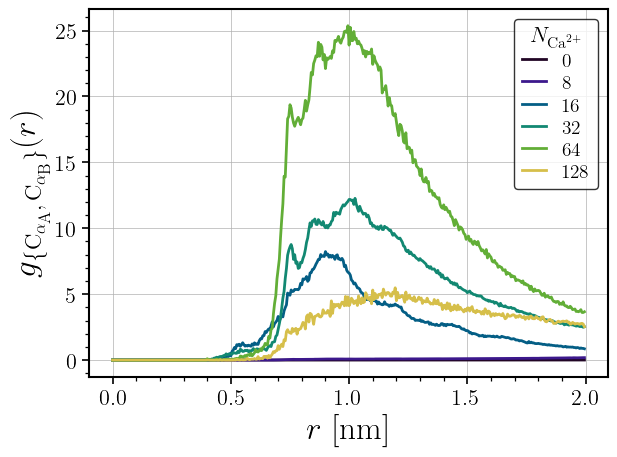

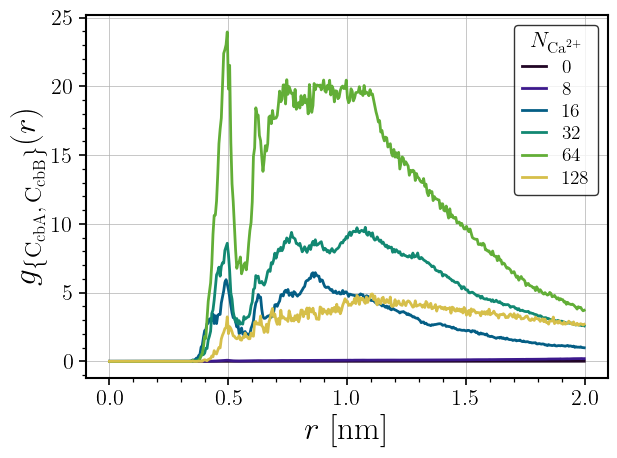

In [26]:
for fname, sg, ylabel, atr in zip(fnames[:2], same_group[:2], ylabels[:2], attributes[:2]):
    fname_up = f"{fname}_corr"
    n_pair = 32 * 16
    print(f"Calculating RDF for {fname_up}")

    dfs = []
    for d in data_list:
        box_vol = (d.info["box_size_nm"] * 10.0) ** 3
        if verbose:
            print(f"Calculating RDF for {d.tag}")
            print(f" - Box volume: {box_vol:.2f} nm^3")

        # get class variable with attribute name
        df = getattr(d, atr).copy()
        for i in range(0, 16):
            df.drop(
                labels=[f"ag1_{i}_ag2_{j}" for j in range(0, 16)], 
                axis=1,
                inplace=True,
            )
        for i in range(16, 32):
            df.drop(
                labels=[f"ag1_{i}_ag2_{j}" for j in range(16, 32)], 
                axis=1,
                inplace=True,
            )
        
        assert len(df.filter(regex="ag1_").columns) == 512, f"Wrong number of columns: {len(df.filter(regex='ag1_').columns)}"

        dfi = rdf(
            df,
            box_vol,
            r_max=r_max,
            n_bins=n_bins,
            verbose=verbose,
            same_group=sg,
            n_pair=n_pair,
        )
        dfs.append(dfi)

    fig, ax = plot_rdf(dfs, n_ca, ax=None)
    ax.set_ylabel(ylabel)

    fig.savefig(f"{fname_up}.png", transparent=False, dpi=300)
    fig.savefig(f"{fname_up}.pdf", transparent=True, dpi=1200)
    print("")
    print("")

In [27]:
verbose = True
r_max = 12.0
n_bins = int(20 * r_max)

Calculating RDF for rdf_calpha_ab
Calculating RDF for 2PAcr-16mer-0Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_10071-idx_00
 - Box volume: 1691215.61 nm^3
Preparing distance matrix
 - Finished in 0.64 s
 - 254341 frames, 1024 distances
Preparing histogram inputs
 - Finished in 1.96 s
 - Flattened distance matrix has shape (70175762,)
 - Flattened weight array has shape (70175762,)
Calculating weighted histogram
 - Finished in 5.25 s
 - Normalization data: 254341.0000
 - Normalization weight: 0.0001
 - Normalization density: 0.0006
 - Normalization volume 1: 0.0037
 - Radial distribution function asymptote: 11.2814
 - Factor difference from 1: 0.0886
Calculating RDF for 2PAcr-16mer-8Ca-0Na-hremd_wtmetad_prod-12.0nm_box-jid_5-idx_01
 - Box volume: 1693576.10 nm^3
Preparing distance matrix
 - Finished in 0.59 s
 - 251120 frames, 1024 distances
Preparing histogram inputs
 - Finished in 1.98 s
 - Flattened distance matrix has shape (74895494,)
 - Flattened weight array has shape (74895494,)
Ca

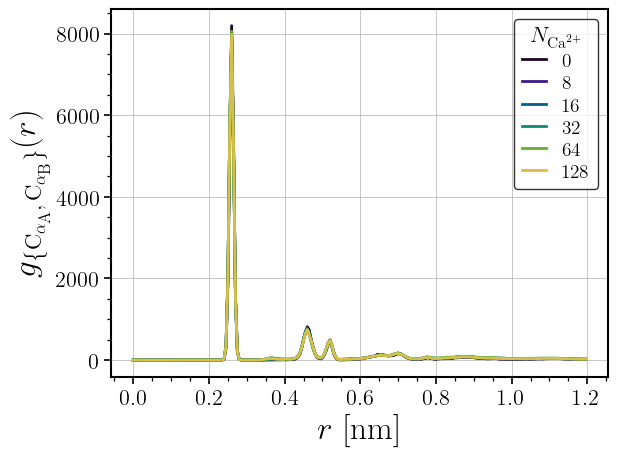

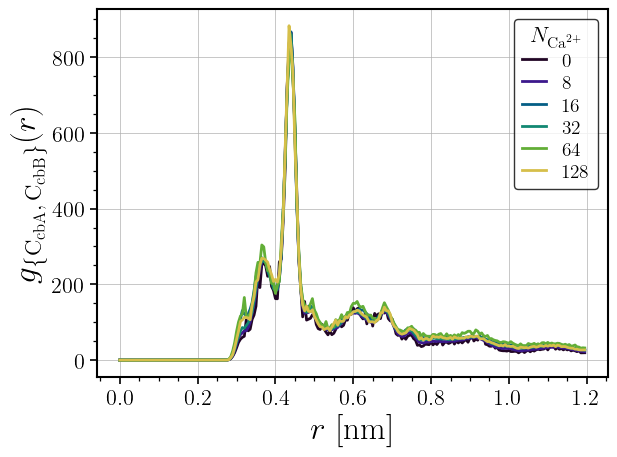

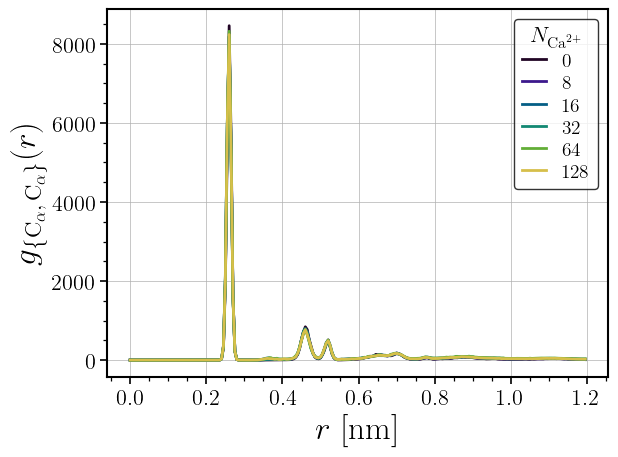

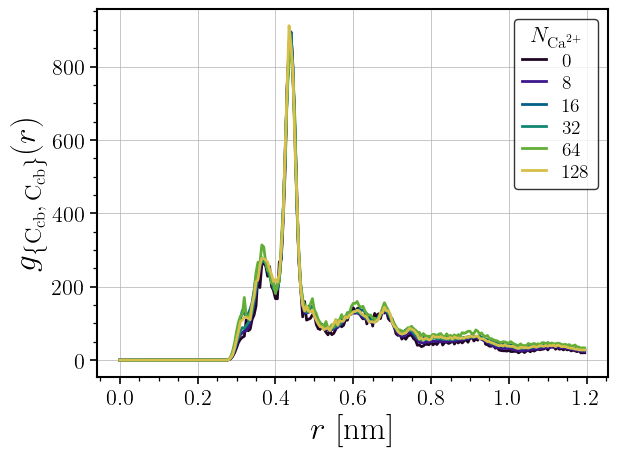

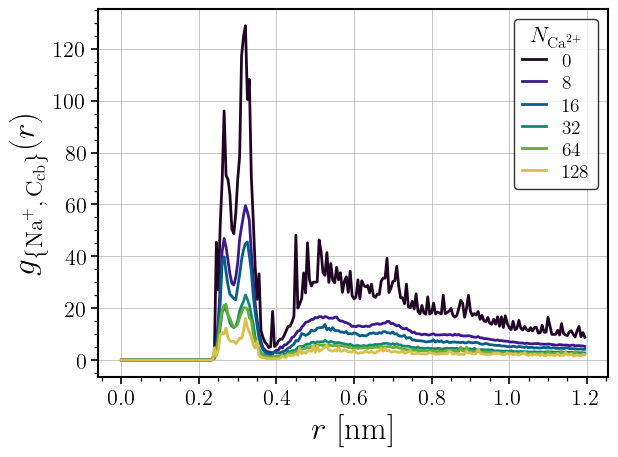

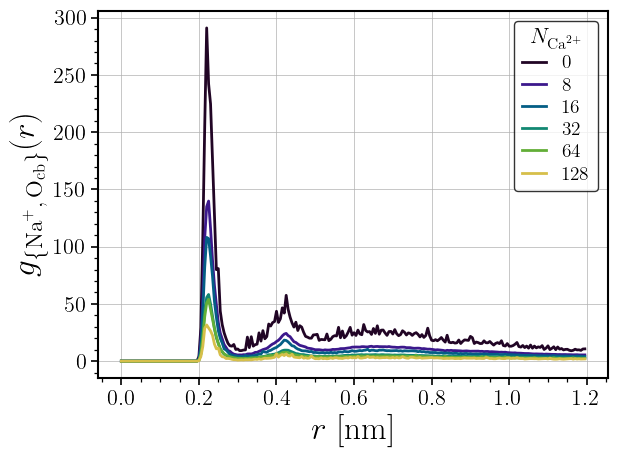

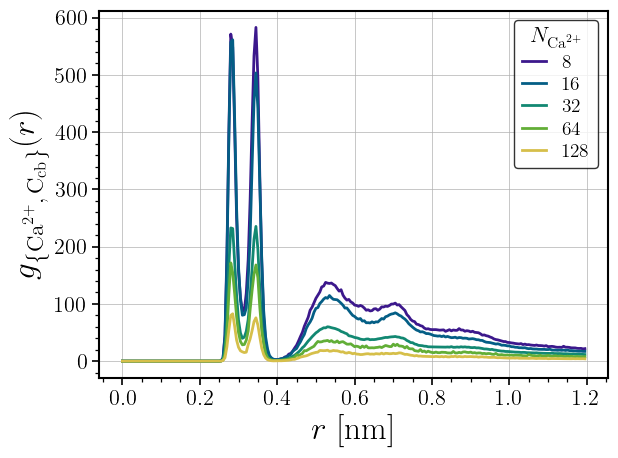

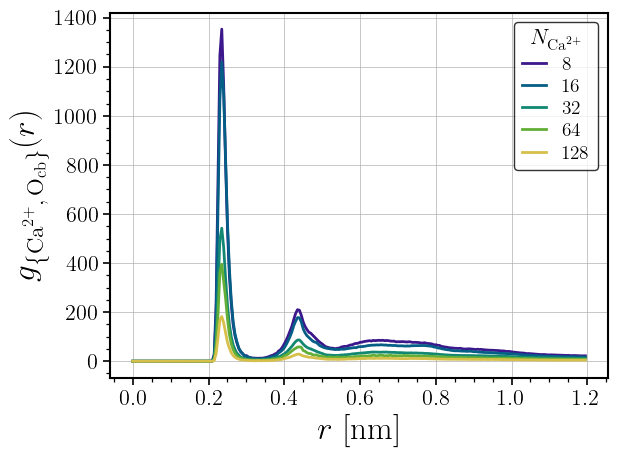

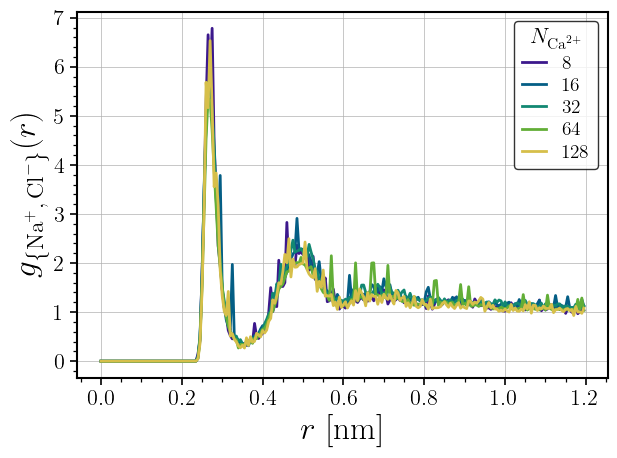

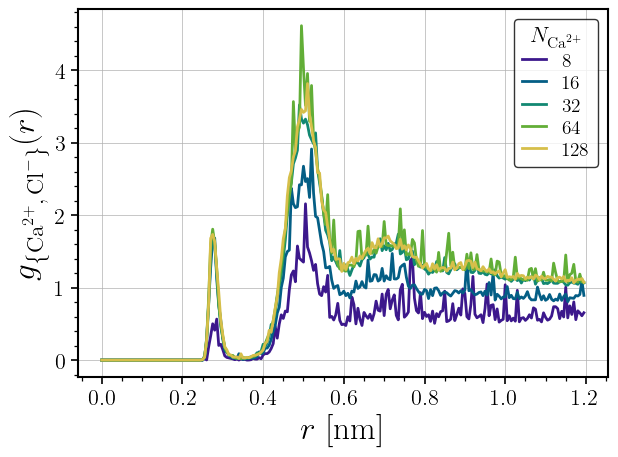

In [28]:
# RDFs
figs, axs = [], []
dfs_all = []
for fname, sg, ylabel, atr in zip(fnames, same_group, ylabels, attributes):
    print(f"Calculating RDF for {fname}")
    dfs = []
    for d in data_list:
        box_vol = (d.info["box_size_nm"] * 10.0) ** 3
        if verbose:
            print(f"Calculating RDF for {d.tag}")
            print(f" - Box volume: {box_vol:.2f} nm^3")

        # get class variable with attribute name
        info = getattr(d, atr)
        if info is None:
            print(f" - Skipping {d.tag}")
            dfs.append(None)
            continue
        else:
            df = getattr(d, atr).copy()

        dfi = rdf(
            df,
            box_vol,
            r_max=r_max,
            n_bins=n_bins,
            verbose=verbose,
            same_group=sg,
        )
        dfs.append(dfi)

    fig, ax = plot_rdf(dfs, n_ca, ax=None)
    ax.set_ylabel(ylabel)
    figs.append(fig), axs.append(ax), dfs_all.append(dfs)

    fig.savefig(f"{fname}.png", transparent=False, dpi=300)
    fig.savefig(f"{fname}.pdf", transparent=True, dpi=1200)
    print("")
    print("")